# Getting tree tops

This notebook takes an orthophoto in TIFF format as input, extracts individual deciduous trees from it and crops them as individual images. These images can then be used to train a model. 

1. In the first step, the tree tops are extracted from the orthophoto using local maxima. With this method pixels in a canopy height model are identified as tree tops if they have the maximum height value in a defined neighborhood. The result is a CSV file in which the geo data of all identified tree tops are stored.

2. In the second step, the normalized difference vegetation index (NDVI) is used to distinguish between conifers and deciduous. The tree canopy data is taken from the CSV file to extract box images of individual trees. These images are then used to compare vegetation indices between the summer and winter seasons. While conifers should exhibit a similar vegetation index in winter and summer, the vegetation index should be very different between seasons for deciduous. The result is a CSV file in which only the geo data of deciduous tree tops is stored.

3. In the third step, we use the extracted coordinates of deciduous trees to correct the GPS data of the labeled trees. As GPS information can be inaccurate by several meters – especially in forests. The goal is to move the labeled data as precisely as possible to a tree top (local maxima) in the image. The result is a CSV file with the shifted geo data of labeled deciduous trees.

**Data you need for running this notebook:**

1. Orthophoto from the area you want to inspect – the TIFF file must be stored in the data folder

2. Spectral maps from summer and winter of the desired area – both TIFF files must be stored in a NDVI subfolder in the data folder

**Content overview:**

* [Setup](#setup)

* [Step 1: Determine tree tops by calculating local maxima](#determine-tree-tops-by-calculating-local-maxima)

    * [Theoretical Background](#theoretical-background)

    * [Custom Circular Filter](#custom-circular-filter)

    * [Gaussian Smoothing Kernal](#gaussian-smoothing-kernal)

    * [Getting Local Maxima](#getting-local-maxima)

    * [Getting Geo Data of the Local Maxima](#getting-geo-data-of-the-local-maxima)

* [Step 2: Deciduous Distinction via NDVI](#deciduous-distinction-via-ndvi)

    * [Customized Functions](#customized-functions)

    * [Getting Deciduous Trees](#getting-deciduous-trees)

* [Step 3: Shifting geo coordinates of labeled trees](#shifting-geo-coordinates-of-labeled-trees)

---

---

## Setup

In [1]:
# import packages

import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.plot import reshape_as_image


from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy import ndimage as ndi

import tensorflow as tf
import keras
from pathlib import PurePath, Path

In [2]:
# load data

im = plt.imread('./data/Lidar2021_vegheight_int16_04m_dm_weg30m.tif')

/Users/chris/Documents/bff/capstone-project_black-forest-forecasters/.venv/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (96284935 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


----

---

## Determine tree tops by calculating local maxima

### Theoretical Background

A maximum filter is pushed over the image. This dilates the original image and merges neighboring local maxima closer than the size of the dilation. If a pixel remains unchanged after dilation, then that pixel is a local maximum.

In this use case, a custom circular filter is created as this corresponds more to the shape of tree tops seen from above.

Additionally a Gaussian Smoothing Kernal can be applied to remove spurious high vegetation points. The kernal removes details and therefore noise. This will help ensure finding the treetops properly.

Sources:

* [.maximum_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html): used for for local maxima

* [peak_local_max](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html): returns the coordinates of local peaks (maxima) in an image

* Finding local maxima with [peak_local_max](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html) from [scikit-image](https://scikit-image.org/)

* [Scikit-image for trees local maxima detection](https://www.researchgate.net/publication/313120937_Scikit-image_for_trees_local_maxima_detection)

Additional information about the parameters of "peak_local_max":

* [Params 1 – peak_local_max](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max)

* [Params 2 – peak_local_max](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html)

* [Params 3 – peak_local_max](https://rdrr.io/github/keithschulze/supr/man/peak_local_max.html) 

### Custom Circular Filter

Function for a circular filter:

In [3]:
# Define a function that allows the generation of a much larger circular filter that needs a radius and the sie of the filter array
def generate_circle_array(radius, array_size):
    # Create an array filled with zeros
    array = np.zeros(array_size, dtype=int)
    
    # Get the center coordinates
    center_x = (array_size[0] - 1) // 2
    center_y = (array_size[1] - 1) // 2
    
    # Generate the circle
    for x in range(array_size[0]):
        for y in range(array_size[1]):
            if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                array[x, y] = 1
    
    return array

# Define the radius of the circle and the array size
radius = 7
array_size = (15, 15)  # 21x21 array

# Generate the circle array
circle_array = generate_circle_array(radius, array_size)

# Display the array as an image
# plt.imshow(circle_array, cmap='binary')
# plt.show()

Getting the right size of the circular filter:

In [4]:
# Define the size of each pixel in meters
pixel_size = .4

# Define the size of the filter window
window_size = 2.5

# Define the radius that we need to apply
radius = np.ceil(.5 * ((window_size/100) / pixel_size)).astype('int')

# Define the size of the array dimensions
filter_dimension = (2*radius+1).astype('int')

# Gather the filter dimensions in a tuple
filter_array = (filter_dimension, filter_dimension)

# Generate the circular array
circle_filter = generate_circle_array(radius, filter_array)

### Gaussian Smoothing Kernal

In [5]:
# Define the standard deviation (sigma) for the Gaussian kernel
# Adjust this value to control the smoothing strength
sigma = 1.9 

# Apply Gaussian smoothing
im = ndi.gaussian_filter(im, sigma=sigma)

In [6]:
# # Display images with and without kernel for verification if wanted

# fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(im, cmap=plt.cm.gray)
# ax[0].axis('off')
# ax[0].set_title('Original')

# ax[1].imshow(im_smooth, cmap=plt.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('With Gaussian kernel')

### Getting Local Maxima

Finding local maxima:

In [7]:
# Define a threshold for the minimum size of trees in centimeters
height_threshold = 300

# Define minimal allowed distance separating peaks
minimal_distance = 1

In [8]:
# Getting the local maxima with peak_local_max function using the circular filter
# If indices=False a raster of the maximum points is returned, as opposed to a list of coordinates
image_max = ndi.maximum_filter(im, footprint=circle_filter, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=minimal_distance, threshold_abs=height_threshold)

In [9]:
# # Display results on the image if wanted

# fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
# ax = axes.ravel()
# ax[0].imshow(im, cmap=plt.cm.gray)
# ax[0].axis('off')
# ax[0].set_title('Original')

# ax[1].imshow(image_max, cmap=plt.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('Maximum filter')

# ax[2].imshow(im, cmap=plt.cm.gray)
# ax[2].autoscale(False)
# ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[2].axis('off')
# ax[2].set_title('Peak local max')

# fig.tight_layout()

# plt.show()

Compare different Gaussian Kernels (if unsure which one to use)

In [10]:
# # Define the range of sigma values (from ... to ..., incremented by ...)
# sigma_values = np.arange(0, 2.5, 0.1)

# # Define height_threshold and minimal_distance
# height_threshold_comparison = 300
# minimal_distance_comparison = 1

# # List to store the number of local maxima for each sigma value
# num_local_maxima_list = []
# for sigma_comparison in sigma_values:
#     # Apply Gaussian filter
#     smoothed_im = ndi.gaussian_filter(im, sigma=sigma_comparison)
#     # Find local maxima
#     image_max = ndi.maximum_filter(smoothed_im, footprint=circle_filter, mode='constant')
#     coordinates_comparison = peak_local_max(smoothed_im, min_distance=minimal_distance_comparison, threshold_abs=height_threshold_comparison)
#     num_local_maxima = len(coordinates_comparison)
#     num_local_maxima_list.append(num_local_maxima)

# # Create a DataFrame to store the results
# df_sigma_comparison = pd.DataFrame({'Sigma': sigma_values, 'Number of Local Maxima': num_local_maxima_list})

# # Calculate the difference in the number of local maxima from one sigma value to another
# # add it as a new column
# df_sigma_comparison['Difference'] = df_sigma_comparison['Number of Local Maxima'].diff()

# df_sigma_comparison

### Getting Geo Data of the Local Maxima

In [11]:
# turn array with coordinates into df
df_coordinates = pd.DataFrame(coordinates)

# assign x and y
x = df_coordinates[0]

y = df_coordinates[1]

In [12]:
# Getting geo information from the original data by opening it as a raster
# Transform it – otherwise the geo data is mirrored
src = rasterio.open('./data/Lidar2021_vegheight_int16_04m_dm_weg30m.tif')

crs = src.crs
transform = src.transform

In [13]:
# List to store the local maxima coordinates
treetop = []

# Assuming 'x' and 'y' are the lists containing the local maxima coordinates
for i in range(len(x)):
    # Determine the coordinate of this local maximum
    lon, lat = rasterio.transform.xy(transform, x[i], y[i])
    treetop.append((lon, lat))

In [14]:
# Turn list of tree tops into a dataframe
df_ttc = pd.DataFrame(treetop)

# Rename the coordinate columns
df_ttc.columns = ["X", "Y"]

# Show the data frame
# df_ttc.head()

Save Tree Tops Geo Data as CSV

In [15]:
# Save the tree top coordinates in a .csv file

# df_ttc.to_csv('./data/treetop_coordinates_thresh' + str(height_threshold) + '_win' + str(window_size) + 'min_dis' + str(minimal_distance) + '_gauss' + str(sigma) + '.csv', index=False)

df_ttc.to_csv('./data/tree_top_coordinates_all.csv')

---

---

## Deciduous Distinction via NDVI

### Customized Functions

Function to import spectral data:

In [16]:
# Define a function to load raster data
def load_raster_data(path):

    # Report that spectral data will be loaded
    print('Started the loading of spectral data.', end='\n')

    # Preload the data
    with rasterio.open(path) as data:
        
        # Extract the data from each frequency band and reshape the resulting
        # array
        data_band = [band for band in data.read()]
        data_spec = reshape_as_image(data_band)

        # Extract info regarding the transformation of pixel to geo-
        # coordinates
        transform = data.transform
    
    # Report that spectral data have been loaded
    print('Finished the loading of spectral data.', end='\n\n')

    # Return the spectral information as well as the transformation matrix
    return data_spec, transform

Function to import tree top data:

In [17]:
# Define a function to load tree top coordinates
def load_treetop_coordinates(path):

    # Report that tree coordinates will be loaded
    print('Started the loading of tree coordinates.', end='\n')

    # Import data that contains the coordinate information on each detected 
    # tree top; needs to be a .csv file with two columns for the first,
    # x coordinates and second, y coordinates
    ttc_df = pd.read_csv(path)

    # Report that tree coordinates have been loaded
    print('Finished the loading of tree coordinates.', end='\n\n')
    
    # Return the dataframe with tree top coordinates
    return ttc_df

Function to translate coordinates of the tree tops to pixel coordinates:

In [18]:
# Define a function to translate geo-coordinates to pixel coordinates
def pixel_coordinate_translation(ttc_df, transform):

    # Report that geo coordinates will be translated to pixel coordinates
    print('Started the translation of tree coordinates from geo to pixel.',
          end='\n')
    
    # Create two new columns in the tree top coordinate data frame that will
    # contain the pixel coordinate information
    ttc_df['x_pix'] = np.full(ttc_df.shape[0], fill_value=np.nan)
    ttc_df['y_pix'] = np.full(ttc_df.shape[0], fill_value=np.nan)

    # Loop through the coordinates of all tree tops
    for i, row in ttc_df.iterrows():

        # Extract the coordinate information of a single tree top
        longitude = row['X'] # changed here
        latitude = row['Y'] # changed here

        # Translate the coordinate to a pixel coordinate
        y_pix, x_pix = ~transform * (longitude, latitude)

        # Add the pixel coordinates to the data frame
        ttc_df.loc[i,'x_pix'] = x_pix
        ttc_df.loc[i,'y_pix'] = y_pix

        # Report progress each time after 1000 tree top coordinates have been
        # translated
        if (((i+1)%1000) == 0) and (((i+1)%10000) > 0):
            print('.', end='')
        elif (((i+1)%10000) == 0):
            print('; ' + str(i+1) + ' tree coordinates have been ' + 
                'translated (' + str((100*i)//ttc_df.shape[0]) + '%)', 
                end='\n')
        elif ((i+1) == ttc_df.shape[0]):
            print('; ' + str(i+1) + ' tree coordinates have been ' + 
                'translated (' + str(100) + '%)', end='\n')

    # Report that geo coordinates have been translated to pixel coordinates
    print('Finished the translation of tree coordinates from geo to pixel.',
          end='\n\n')

    # Return the pixel coordinates that have been added to the dataframe
    return ttc_df

Function to extract image boxes around each tree top pixel coordinate:

In [19]:
# Define a function to extract image boxes around tree top pixel coordinates
def extract_treetop_imageboxes(ttc_df, data_spec):

    # Report that image boxes will be extracted from the spectral data
    print('Started the extraction of image boxes.', end='\n')

    # Define the size of the box as an odd number to center it on the exact
    # tree top pixel coordinate
    box_size = 35

    # Define an array that will contain all box images
    tt_box_img = np.full((ttc_df.shape[0], box_size, box_size, 4), \
                        fill_value=np.nan)

    # Iterate through all rows of the tree top pixel coordinates
    for i, row in ttc_df.iterrows():

        # Get the pixel coordinate of the tree top
        x_ttpc = int(row['x_pix'])
        y_ttpc = int(row['y_pix'])

        # Define the pixel coordinate limits of the image
        x_max_img = int(data_spec.shape[0])
        y_max_img = int(data_spec.shape[1])

        # Define the pixel coordinates of the box
        y_min_box = y_ttpc - box_size//2
        y_max_box = y_ttpc + box_size//2 + 1
        x_min_box = x_ttpc - box_size//2
        x_max_box = x_ttpc + box_size//2 + 1

        # Check whether the box stays inside of the image limits
        if (y_min_box >= 0) and (y_max_box <= y_max_img) and \
        (x_min_box >= 0) and (x_max_box <= x_max_img):
            
            # Extract the box image
            box_img = data_spec[x_min_box:x_max_box,y_min_box:y_max_box,:]

            # Check whether all pixels in the box contain information
            if np.all(np.sum(box_img, axis=2) > 0, axis=(0,1)):

                # Save the image for further processing
                tt_box_img[i,:,:,:] = box_img

        # Report progress each time after 1000 boxes have been extracted
        if (((i+1)%1000) == 0) and (((i+1)%10000) > 0):
            print('.', end='')
        elif (((i+1)%10000) == 0):
            print('; ' + str(i+1) + ' trees have been processed (' + 
                str((100*i)//ttc_df.shape[0]) + '%)', end='\n')
        elif ((i+1) == ttc_df.shape[0]):
            print('; ' + str(i+1) + ' trees have been processed (' + 
                str(100) + '%)', end='\n')
            
    # Report that image boxes have been extracted from the spectral data
    print('Finished the extraction of image boxes.', end='\n\n')

    # Return the array containing all image boxes placed around tree tops
    return tt_box_img

Function to calculate the normalized differentiated vegetation index (NDVI):

In [20]:
# Create an image for displaying a biomass index, using the property of the
# red channel that reflects the degree of chlorophyll pigments and the
# reflection degree of plants reflected in the near-infrared channel
# https://tinyurl.com/a9r5dhft

# Define a function to calculate the ndvi
def calculate_ndvi(ttc_df, tt_box_img_summer, tt_box_img_winter):

    # Report that ndvi scores will be calculated
    print('Started the calculation of ndvi scores.', end='\n')    

    # Calculate the ndvi for the summer
    ndvi_summer = ((tt_box_img_summer[:,:,:,3] - tt_box_img_summer[:,:,:,0]) / 
                (tt_box_img_summer[:,:,:,3] + tt_box_img_summer[:,:,:,0]))

    # Calculate the summer average
    ndvi_summer_avg = np.mean(ndvi_summer, axis=(1,2))

    # Calculate the ndvi for the winter
    ndvi_winter = ((tt_box_img_winter[:,:,:,3] - tt_box_img_winter[:,:,:,0]) / 
                (tt_box_img_winter[:,:,:,3] + tt_box_img_winter[:,:,:,0]))

    # Calculate the winter average
    ndvi_winter_avg = np.mean(ndvi_winter, axis=(1,2))

    # Calculate the difference between summer and winter
    ndvi_avg_diff = ndvi_summer_avg - ndvi_winter_avg

    # Append information to the data frame
    ttc_df['ndvi_summer_avg'] = ndvi_summer_avg
    ttc_df['ndvi_winter_avg'] = ndvi_winter_avg
    ttc_df['ndvi_diff_avg']   = ndvi_avg_diff

    # Report that ndvi scores have been calculated
    print('Finished the calculation of ndvi scores.', end='\n\n')  

    # Return the ttc_df as well as arrays of ndvi
    return ttc_df, ndvi_summer, ndvi_winter

Function to find a decision boundary to distinguish conifers from deciduous:

In [21]:
# Define a function that performs a distinction between conifers and
# deciduous
def check_for_deciduous(ttc_df):

    # Report that tree tops will be assigned to either conifers or deciduous
    print('Started the distinction between conifers and deciduous.',
          end='\n')

    # Define a threshold for classifying a conifer and hence drop its tree
    # top from erroneously assigning it to be a deciduous
    thresh = .45

    # Add to the tree top coordinates the information whether the full image
    # contains information
    ttc_df['img_complete'] = (np.isnan(ttc_df['ndvi_diff_avg']) == False)

    # Report on how many tree tops have a complete image information
    print(str(round(100*np.mean(ttc_df['img_complete']))) + 
          '% of all tree tops have been marked to be part of a ' + 
          'complete image.')
    
    # Add to the tree top coordinates the information whether it contains
    # a deciduous
    ttc_df['img_deciduous'] = ttc_df['ndvi_diff_avg'] > thresh

    # Report on how many tree tops have been classified as deciduous trees
    print(str(round(100*np.mean(ttc_df['img_deciduous']))) +
          '% of all tree tops have been marked as being deciduous.')

    # Report that tree tops have been assigned to either conifers or
    # deciduous
    print('Finished the distinction between conifers and deciduous.',
          end='\n\n')
    
    # Return the data frame that already contains the tree top coordinates, 
    # now with the additional ndvi information
    return ttc_df

### Getting Deciduous Trees

Execute all functions to distinguish between conifers and deciduous and save results in a CSV file:

In [22]:
# Announce that processing has started
print('\nProcessing has started!', end='\n\n')

# Load spectral data from the summer
summer_spec, transform = \
    load_raster_data('./data/NDVI/TDOP_2022_weg30m.tif')

# Load spectral data from the winter
winter_spec, transform = \
    load_raster_data('./data/NDVI/TDOP_2021_weg30m.tif')

# Load the tree top coordinates
ttc_df = load_treetop_coordinates('./data/tree_top_coordinates_all.csv')

# Translate geo coordinates of tree tops to pixel coordinates and add them
# to the previous data frame
ttc_df = pixel_coordinate_translation(ttc_df, transform)

# Extract image boxes around tree top coordinates for the summer data
tt_box_img_summer = extract_treetop_imageboxes(ttc_df, summer_spec)

# Extract image boxes around tree top coordinates for the winter data
tt_box_img_winter = extract_treetop_imageboxes(ttc_df, winter_spec)

# Calculate the ndvi
ttc_df, ndvi_summer, ndvi_winter = \
    calculate_ndvi(ttc_df, tt_box_img_summer, tt_box_img_winter)

# Add the nvdi information to the data frame and classify tree tops to
# either belong to conifers or deciduous
ttc_df = check_for_deciduous(ttc_df)

# Save the tree top data frame
ttc_df.to_csv('./data/tree_top_coordinates_deciduous.csv', index=False)

# Announce that processing has finished
print('Processing has finished!', end='\n')


Processing has started!

Started the loading of spectral data.
Finished the loading of spectral data.

Started the loading of spectral data.
Finished the loading of spectral data.

Started the loading of tree coordinates.
Finished the loading of tree coordinates.

Started the translation of tree coordinates from geo to pixel.
.........; 10000 tree coordinates have been translated (22%)
.........; 20000 tree coordinates have been translated (45%)
.........; 30000 tree coordinates have been translated (67%)
.........; 40000 tree coordinates have been translated (90%)
....; 44410 tree coordinates have been translated (100%)
Finished the translation of tree coordinates from geo to pixel.

Started the extraction of image boxes.
.........; 10000 trees have been processed (22%)
.........; 20000 trees have been processed (45%)
.........; 30000 trees have been processed (67%)
.........; 40000 trees have been processed (90%)
....; 44410 trees have been processed (100%)
Finished the extraction o

Plot the NDVI for summer, winter and their difference:

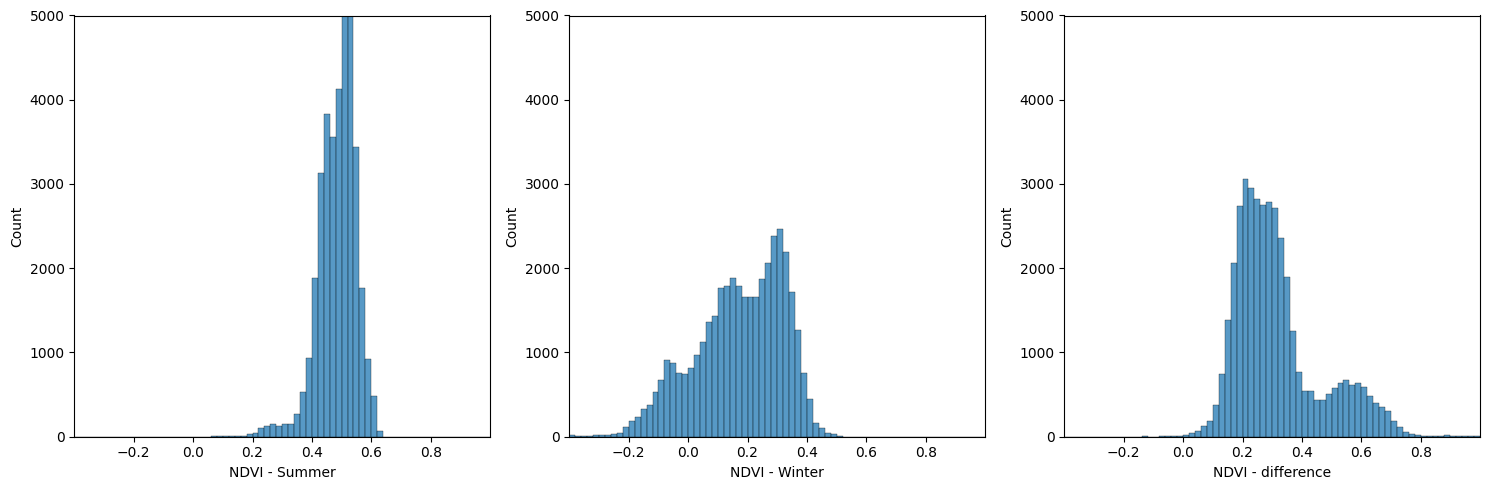

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the ndvi for the summer
fig0 = sns.histplot(ttc_df['ndvi_summer_avg'], ax=ax[0], bins=100,
                    binrange=(-1,1))
ax[0].set_xlim(-.4, 1)
ax[0].set_ylim(0, 5000)
fig0.set(xticks=np.arange(-.2,1.0,.2))
fig0.set(xlabel='NDVI - Summer');

# Plot the ndvi for the winter
fig1 = sns.histplot(ttc_df['ndvi_winter_avg'], ax=ax[1], bins=100,
                    binrange=(-1,1))
ax[1].set_xlim(-.4, 1)
ax[1].set_ylim(0, 5000)
fig1.set(xticks=np.arange(-.2,1.0,.2))
fig1.set(xlabel='NDVI - Winter');

# Plot the ndvi for the summer-winter
fig2 = sns.histplot(ttc_df['ndvi_diff_avg'], ax=ax[2], bins=100,
                    binrange=(-1,1))
ax[2].set_xlim(-.4, 1)
ax[2].set_ylim(0, 5000)
fig2.set(xticks=np.arange(-.2,1.0,.2))
fig2.set(xlabel='NDVI - difference');

plt.tight_layout()
plt.show()

Plot the NDVI only for the difference summer - winter:

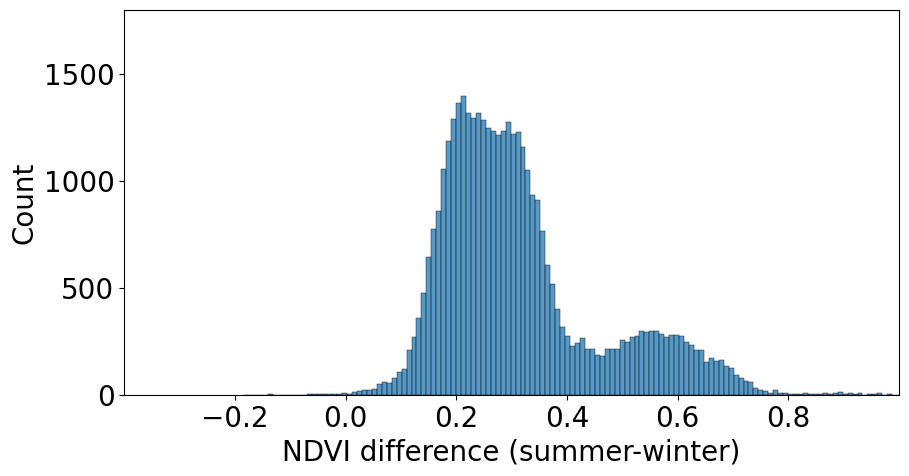

In [24]:
# Plot the ndvi for the summer-winter
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig = sns.histplot(ttc_df['ndvi_diff_avg'])
ax.set_xlim(-.4, 1.0)
ax.set_ylim(0, 1800)
fig.set(xlabel='NDVI difference (summer-winter)')
fig.set(xticks=np.arange(-.2, 1, .2));


Conclusion from the plot:

* Two extrema should be distinguishable by eye. In the original use case: A large extrema formed around .25 while a smaller one formed around .55

* Differences closer to zero likely result from NDVI values being similar in summer and winter (conifers) while larger values likely result from NDVI values being larger in summer and smaller in winter (deciduous)

* Accordingly, all trees that form the second smaller extrema are the trees that should be included in the upcoming analysis pipeline

* Based on the plot, a lower and upper value for the NDVI of deciduous trees must now be defined. In the original use case, this was defined from .35 to .75 

* As long as the NDVI difference ranges between these two values (or larger), we will assume that the tree in the box image is a deciduous tree

---

---

## Shifting geo coordinates of labeled trees

The general aim of this step is to shift each tree coordinate to the tree top that is closest to it. As it occurs that multiple tree coordinates are shifted to the same treetop, these duplicate assignments need to be handled so that only the assignment with the shortest distance remains.

Import tree top coordinates:

In [25]:
# Load the tree top coordinates
ttc_df = pd.read_csv('./data/tree_top_coordinates_deciduous.csv')

# Only keep treetops with complete box images and a deciduous tree content
ttc_df = ttc_df[(ttc_df['img_complete'] == True) & (ttc_df['img_deciduous'] == True)]

# Drop columns that are not important anymore
ttc_df = ttc_df[['X', 'Y']] # the geo coordinates of extracted trees are not necessary anymore since we are working with the pixel coordinates

# Add an identifier
ttc_df['id'] = np.arange(0, ttc_df.shape[0], 1)

# Reset the index as rows have been dropped
ttc_df.reset_index(drop=True, inplace=True)

Import the coordinates of the original but cleaned labeled trees:

In [26]:
# Load the tree coordinates
tc_df = pd.read_csv('./data/Laubbäume_utm32_cleaned.csv')

# Only extract columns that will be relevant in the further processing
tc_df = tc_df[['X', 'Y', 'desc']]

# Rename columns
tc_df.columns = ['x_geo', 'y_geo', 'label']

# Check for tree coordinates that are duplicates of each other and throw
# them away
tc_df = tc_df[tc_df[['x_geo', 'y_geo']].duplicated(keep=False) == False].\
    reset_index(drop=True)

# Add a column that delineates lists of previous ids of treetops that it
# should have been shifted to but another tree was closer
tc_df['prev_shift_id'] = [[] for _ in range(len(tc_df))]

# Add a column that contains the id of the treetop that the tree coordinate
# is currently shifted to
tc_df['last_shift_id'] = [np.nan for _ in range(len(tc_df))]

# Add a column that contains the distance of the tree coordinate from the
# treetop that it is currently shifted to
tc_df['last_distance'] = [np.nan for _ in range(len(tc_df))]

In [30]:
tc_df.columns

Index(['x_geo', 'y_geo', 'label', 'prev_shift_id', 'last_shift_id',
       'last_distance'],
      dtype='object')

Define functions for allocating tree coordinates to treetop coordinates:

In [28]:
# Define a function to check whether a list is empty
def check_list_empty(lst):
    return (np.sum(np.isnan(lst)) > 0)

# Define a function to check whether there are any duplicates in a list
def check_list_duplicates(lst):
    return (len(np.unique(lst)) < len(lst))

Perform the allocation of tree coordinates to treetop coordinates:

In [29]:
# Run the following code as long as the list of id allocations is either (1)
# empty or (2) contains duplicates
while check_list_empty(tc_df['last_shift_id']) or \
      check_list_duplicates(tc_df['last_shift_id']):

    # Determine rows that have no treetop allocation
    tta_missing = np.where(np.isnan(tc_df['last_shift_id']))

    # Loop through all tree coordinates that currently have no treetop
    # allocation
    for i in tta_missing[0]:

        # Extract a single tree coordinate
        tc = (tc_df.loc[i,'x_geo'], tc_df.loc[i,'y_geo'])

        # Extract the matching history for this tree coordinate
        tc_hist = tc_df.loc[i,'prev_shift_id']

        # Drop all treetop coordinates that have already been matched with
        # this tree coordinate before
        ttc_dft = ttc_df.drop(tc_hist, axis=0).reset_index(drop=True)

        # Calculate the distance between this tree coordinate and all
        # (remaining) treetop coordinates
        dist_lst = np.sqrt(np.sum((ttc_dft[['x_geo', 'y_geo']] - tc) ** 2,
                                  axis=1))
        
        # Find the treetop index with the minimum distance
        ind_min = np.argmin(dist_lst)

        # Add this treetop id to the history of matched treetop ids
        tc_df.loc[i,'prev_shift_id'].append(ttc_dft.loc[ind_min,'id'])

        # Set the treetop that corresponds to this minimum distance as the
        # last shift id
        tc_df.loc[i,'last_shift_id'] = ttc_dft.loc[ind_min,'id']

        # Save the distance to allow for comparisons later on
        tc_df.loc[i,'last_distance'] = dist_lst[ind_min]

    # Check for duplicate assignments and summarize the respective treetop
    # ids in a list
    duplicates = tc_df['last_shift_id'].value_counts().reset_index()
    duplicates = \
        duplicates.loc[duplicates['count'] > 1,'last_shift_id'].tolist()

    # Loop through each duplicate value
    for di in duplicates:
        
        # Extract indexes for duplicate assignments
        duplicates_ind = tc_df['last_shift_id'] == di

        # Check for each duplicate treetop coordinate which tree coordinate
        # has the closest distance to it
        dist_min = tc_df.loc[duplicates_ind, 'last_distance'].min()

        # Extract indexes for tree coordinates that do not show that exact
        # distance from their assigned treetop
        distance_ind = (tc_df['last_distance'] != dist_min)

        # Combine indexes to find pairs of tree coordinates and treetops
        # that need be unassigned again as they do not show the shortest
        # distance between each other
        farther_ind = np.where(duplicates_ind & distance_ind)

        # Assign these tree coordinates once again an nan so that a new
        # treetop can be found for them
        tc_df.loc[farther_ind[0],'last_shift_id'] = np.nan
        tc_df.loc[farther_ind[0],'last_distance'] = np.nan

KeyError: "None of [Index(['x_geo', 'y_geo'], dtype='object')] are in the [columns]"

Assign each tree coordinate its new tree top coordinate:

In [ ]:
# Predefine new columns that will contain the allocated treetop coordinates
tc_df['x_geo_new'] = [np.nan for _ in range(len(tc_df))]
tc_df['y_geo_new'] = [np.nan for _ in range(len(tc_df))]

# Loop through all tree coordinates
for i in range(len(tc_df)):

    # Assign each tree coordinate its new tree top coordinate
    tc_df.loc[i,'x_geo_new'] = \
        ttc_df.loc[tc_df.loc[i,'last_shift_id'],'x_geo']
    tc_df.loc[i,'y_geo_new'] = \
        ttc_df.loc[tc_df.loc[i,'last_shift_id'],'y_geo']    

# Extract relevant columns and rearrange them
tc_df = tc_df[['x_geo', 'x_geo_new', 'y_geo', 'y_geo_new', 'label',
               'last_shift_id', 'last_distance']]

# Relabel the columns
tc_df.columns = ['x_geo', 'x_geo_new', 'y_geo', 'y_geo_new', 'label',
                 'treetop_id', 'distance']

# Save the resulting data frame
tc_df.to_csv('../data/Laubbäume_utm32_shifted.csv', index=False)

Plot the resulting distances for shifting tree on treetop coordinates:

In [ ]:
# Plot a histogram comprising all distances but cut at 250 so that outliers
# are not considered in scaling the axes
sns.histplot(tc_df.loc[tc_df['distance'] < 250, 'distance']);